# Analysis of Trending YouTube Video Statistics


Objective: Analyze the data of U.S trending YouTube videos between 2017 and 2019 to find correlations and relationships between video characteristics. Methods used in the project include A/B testing, bootstrapping, visualizations, and data sorting and cleaning.

By Jack Chen, UC Berkeley Class of 2023

ichiachen1@berkeley.edu 


In [1]:
from datascience import *
import numpy as np
from math import *
import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
import warnings
warnings.simplefilter('ignore', FutureWarning)

### Trending YouTube Statistics Dataset

In [2]:
yt_vids = Table.read_table('USvideos.csv')
yt_vids.show(1)

video_id,trending_date,title,channel_title,category_id,publish_time,tags,views,likes,dislikes,comment_count,thumbnail_link,comments_disabled,ratings_disabled,video_error_or_removed,description
2kyS6SvSYSE,17.14.11,WE WANT TO TALK ABOUT OUR MARRIAGE,CaseyNeistat,22,2017-11-13T17:13:01.000Z,SHANtell martin,748374,57527,2966,15954,https://i.ytimg.com/vi/2kyS6SvSYSE/default.jpg,False,False,False,SHANTELL'S CHANNEL - https://www.youtube.com/shantellmar ...


### Question 1: Do All Capital Letters in the Video Titles Result in More Views?


We will be answering this question since the number of views is a large factor into whether a YouTube video becomes trending or not.

In order to answer this question, we will conduct a hypothesis test (A/B testing), splitting the videos into two groups: one group with all capital letter title videos and another group with non-all capital letter title videos. 

>Null hypothesis: Among the trending videos, the distribution of the views is the same for videos with all capital letter titles as for videos with non-all capital letter titles. Any difference is in the sample is due to chance.

>Alternative hypothesis: The distribution of the views is different between videos with all capital letter titles and videos with non-all capital letter titles.

>Test statistic: Average number of views for videos with all capital letters in the title - average number of views for videos with non-all capital letters in the title.

In [34]:
# Dropped unnecessary columns such as Video ID

dropped_columns = yt_vids.drop('video_id', 'category_id', 'thumbnail_link', 'video_error_or_removed')

### Table With Information of Videos That Were All in Capital Letters.

In [35]:
def uppercasewords(x):
    '''Finds whether words in a string are all upper case'''
    return x.isupper()

upper_cases = dropped_columns.apply(uppercasewords, 'title')
all_caps_vids = dropped_columns.with_column('All Caps', upper_cases).where('All Caps', are.equal_to(1))
not_all_caps = dropped_columns.with_column('Not All Caps', upper_cases).where('Not All Caps', are.equal_to(0))

In [36]:
average_view_caps = np.average(all_caps_vids.column('views'))

print('Average views of videos with all capital letter titles:', average_view_caps, 'views')

Average views of videos with all capital letter titles: 1571173.4019984626 views


In [37]:
average_view_not_caps = np.average(not_all_caps.column('views'))

print('Average views of videos with non-all capital letter titles:', average_view_not_caps, 'views')

Average views of videos with non-all capital letter titles: 2414362.973896263 views


In [38]:
def diff(x, y):
    '''Finds difference between two numbers of arrays x and y'''
    return x - y

observed_diff = diff(average_view_caps, average_view_not_caps)
print('Observed test statistic:', observed_diff, 'views')

Observed test statistic: -843189.5718978005 views


### Simulating Empirical Test Statistic

In [39]:
print('Number of rows in all capital letter table:', all_caps_vids.num_rows, 'rows')
print('Number of rows in non-all capital letter table:', not_all_caps.num_rows, 'rows')

Number of rows in all capital letter table: 2602 rows
Number of rows in non-all capital letter table: 38347 rows


>Since the sample size is drastically different between videos with all capital letter titles and videos with non-all capital letter titles, we will bootstrap random samples of 2602 rows from the table of non-all capital letter titles 25 times to simulate equal representation in sample size and a more accurate representation of average views from non-all capital letter title videos.

In [9]:
# Simulated test statistic

view_diff = make_array()
views = make_array()

for i in np.arange(200):
    shuffled_vids = dropped_columns.sample(with_replacement=False)
    shuffled_label = shuffled_vids.column('title')
    added_title = dropped_columns.with_column('title', shuffled_label)
    caps_vids = added_title.apply(uppercasewords, 'title')
    caps = added_title.with_column('Caps', caps_vids)
    avg_caps = np.average(caps.where('Caps', are.equal_to(1)).column('views'))
    
    for i in np.arange(25):
        sampled_not_caps = caps.where('Caps', are.equal_to(0)).sample(2602, with_replacement=True)
        avg_not_caps = np.average(sampled_not_caps.column('views'))
        views = np.append(views, avg_not_caps)
    
    view_diff = np.append(view_diff, avg_caps - np.average(views))

The approximate 95% confidence interval is: -281039.0 to 273172.0


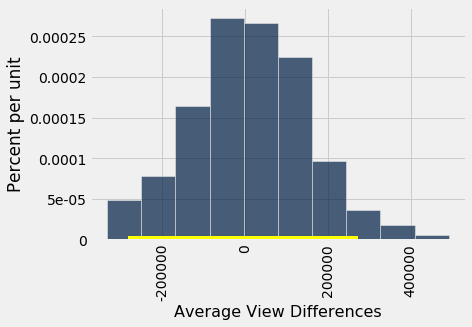

In [23]:
# 95% confidence interval

differences_table = Table().with_column('Average View Differences', view_diff)
differences_table.hist()
left = percentile(2.5, view_diff)
right = percentile(97.5, view_diff)

print('The approximate 95% confidence interval is:', round(left), 'to', round(right))
plt.plot(make_array(left, right), make_array(0, 0), color='yellow', lw=8);

### Conclusion of Question 1

>With the observed value not lying within the 95% confidence interval, the distribution in the histogram above favors the alternative hypothesis that the distribution of the views is different between videos with all capital letter titles and videos with non-all capital letter titles.

>In fact, all capital letter title videos tend to perform worse than non-all capital letter title videos, as the observed value is negative, indicating that there tends to be less views in all capital letter title videos, on average, than non-all capital letter title videos. 


### Question 2: Do Videos with Disabled Comments Lead to Less Views?

We will be also answering this question since comments can contribute to the number of views, and views are a large factor into whether a YouTube video becomes trending or not.

In order to answer this question, we will conduct a hypothesis test (A/B testing), splitting the videos into two groups: one group of videos with disabled comments and another group of videos without disabled comments. 

>Null hypothesis: The views of videos with disabled comments come from the same underlying distribution as views of videos with non-disabled comments, and any difference is due to random chance.

>Alternative hypothesis: The videos with disabled comments have a **lower** amount of views, on average, compared to the views of non-disabled comment videos.

>Test statistic: Average number of views of disabled comment videos - average number of views of non-disabled comment videos.

In [40]:
# Tables for the two groups 

disabled_ratings = dropped_columns.where('comments_disabled', are.equal_to(1)).column('views')
not_disabled_ratings = dropped_columns.where('comments_disabled', are.equal_to(0)).column('views')

In [42]:
print('Number of rows in disabled comments table:', dropped_columns.where('comments_disabled', are.equal_to(1)).num_rows, 'rows')
print('Number of rows in non-disabled comments table:',dropped_columns.where('comments_disabled', are.equal_to(0)).num_rows, 'rows')

Number of rows in disabled comments table: 633 rows
Number of rows in non-disabled comments table: 40316 rows


>Since the sample size is drastically different between the two groups, we will bootstrap 633 rows from the table of non-disabled comment videos 25 times to simulate equal representation in sample size and a more accurate representation of average views from non-disabled comment videos.

In [14]:
disabled = np.average(disabled_ratings)
not_disabled = np.average(not_disabled_ratings)
differences = disabled - not_disabled
print('Observed test statistic:', differences, 'views')

Observed test statistic: 160438.75367934536 views


In [15]:
# Simulate test statistic

non_d_vids = make_array()
diff_disable_views = make_array()

for i in np.arange(200):
    shuffled_t = dropped_columns.sample(with_replacement=False)
    shuffled_l = shuffled_t.column('comments_disabled')
    added_comments = dropped_columns.with_column('comments_disabled', shuffled_l)
    d_comments = np.average(added_comments.where('comments_disabled', are.equal_to(1)).column('views'))
    
    for i in np.arange(25):
        sample_non_disable = added_comments.where('comments_disabled', are.equal_to(0)).sample(633, with_replacement=True)
        avg_non_disable = np.average(sample_non_disable.column('views'))
        non_d_vids = np.append(non_d_vids, avg_non_disable)
        
    diff_disable_views = np.append(diff_disable_views, d_comments - np.average(non_d_vids))

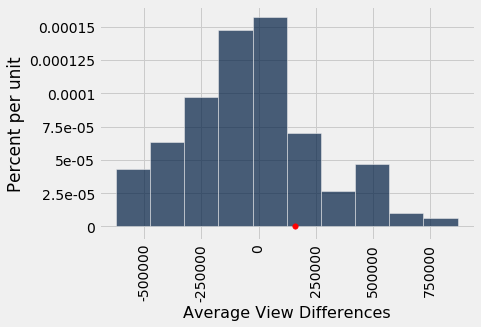

In [26]:
diff_views = Table().with_column('Average View Differences', diff_disable_views)
diff_views.hist()
plt.scatter(differences, 0, color='red', s=30, zorder=2);

In [25]:
# P-value

p_value = np.count_nonzero(diff_disable_views <= differences) / len(diff_disable_views)
p_value

0.805

In [52]:
# Proportion of average view differences that are less than zero 

np.count_nonzero(diff_disable_views <= 0) / len(diff_disable_views)

0.575

### Conclusion of Question 2

>With a p-value cutoff of 5%, our p-value of 0.805 (80.5%) indicates that the distribution in the histogram above is consistent with the null hypothesis that the views of videos with disabled comments come from the same underlying distribution as views of videos with non-disabled comments.

>However, this is odd because our observed value is out of place compared to the majority of the distribution, which is less than zero for the difference in average views between the two groups. This indicates that disabled comment videos seem to have less views, on average, than non-disabled comment videos. Our observed value seems to be an abnormality here (possibily due to the large difference in sample size when calculating the observed statistic).

### Question 3: Do Descriptions Affect the Number of Views in Trending YouTube Videos?

In [31]:
def length(x):
    '''Finds length, in terms of number of characters, of the video descriptions'''
    return len(x)

In [32]:
description_length = dropped_columns.apply(length, 'description')
length_tbl = dropped_columns.with_column('Description Length', description_length).relabel('views', 'Average Views')
print('Average description length is', np.average(length_tbl.column('Description Length')), 'characters')

Average description length is 1031.52277222887 characters


Average views below average description length: 2538400.286585366 views
Average views below average description length: 2081109.2703231508 views


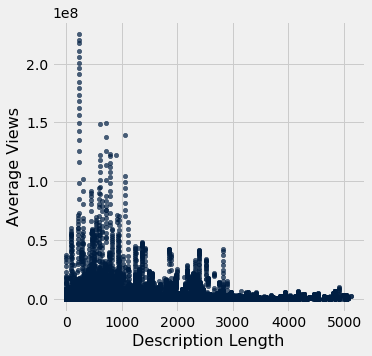

In [33]:
under_avg = length_tbl.where('Description Length', are.below(1055))
above_avg = length_tbl.where('Description Length', are.above(1055))

avg_under = np.average(under_avg.column('Average Views'))
avg_above = np.average(above_avg.column('Average Views'))


print('Average views below average description length:', avg_under, 'views')   
print('Average views below average description length:', avg_above, 'views')   
length_tbl.scatter('Description Length', 'Average Views')

### Conclusion of Question 3
Based on averaging the description length of the videos in the dataset, there tends to be **more views, on average, for videos with description character lengths below 1055 than above 1055**. Also, as seen in the scatter plot above, there seems to be a negative association between the description length and the number of views in trending videos.

### Question 4: What is the Optimal Time to Post a YouTube Video? 


In [10]:
# Table with columns of the features "publish time" and "views"

views_and_time = yt_vids.select('publish_time', 'views')
views_and_time.show(1)      

publish_time,views
2017-11-13T17:13:01.000Z,748374


In [11]:
def year(x):
    '''Finds year of publish time for each video '''
    if x.startswith('2017'):
        return True
    elif x.startswith('2018'):
        return True
    else: 
        return False 

def month(x):
    '''Finds month of publish time for each video '''
    for i in np.arange(0, 13, 1):
        count = i
        if x.startswith('2017-0' + str(count)) == True:
            return str(count) 
        elif x.startswith('2017-1' + str(count)) == True:
            return '1' + str(count)
        elif x.startswith('2018-0' + str(count)) == True:
            return str(count) 
        elif x.startswith('2018-1' + str(count)) == True:
            return '1' + str(count)
        
def day(x):
    '''Finds year of publish time for each video '''
    for i in np.arange(0, 30, 1):
        count = i
        if x.startswith('2017-01-0' + str(count)) == True:
            return str(count) 
        elif x.startswith('2017-01-1' + str(count)) == True:
            return '1' + str(count)
        elif x.startswith('2017-01-2' + str(count)) == True:
            return '2' + str(count)
        elif x.startswith('2017-01-3' + str(count)) == True:
            return '3' + str(count) 
        elif x.startswith('2017-02-0' + str(count)) == True:
            return str(count) 
        elif x.startswith('2017-02-1' + str(count)) == True:
            return '1' + str(count)
        elif x.startswith('2017-02-2' + str(count)) == True:
            return '2' + str(count)
        elif x.startswith('2017-02-3' + str(count)) == True:
            return '3' + str(count) 
        elif x.startswith('2017-03-0' + str(count)) == True:
            return str(count) 
        elif x.startswith('2017-03-1' + str(count)) == True:
            return '1' + str(count)
        elif x.startswith('2017-03-2' + str(count)) == True:
            return '2' + str(count)
        elif x.startswith('2017-03-3' + str(count)) == True:
            return '3' + str(count) 
        elif x.startswith('2017-04-0' + str(count)) == True:
            return str(count) 
        elif x.startswith('2017-04-1' + str(count)) == True:
            return '1' + str(count)
        elif x.startswith('2017-04-2' + str(count)) == True:
            return '2' + str(count)
        elif x.startswith('2017-04-3' + str(count)) == True:
            return '3' + str(count) 
        elif x.startswith('2017-05-0' + str(count)) == True:
            return str(count) 
        elif x.startswith('2017-05-1' + str(count)) == True:
            return '1' + str(count)
        elif x.startswith('2017-05-2' + str(count)) == True:
            return '2' + str(count)
        elif x.startswith('2017-05-3' + str(count)) == True:
            return '3' + str(count) 
        elif x.startswith('2017-06-0' + str(count)) == True:
            return str(count) 
        elif x.startswith('2017-06-1' + str(count)) == True:
            return '1' + str(count)
        elif x.startswith('2017-06-2' + str(count)) == True:
            return '2' + str(count)
        elif x.startswith('2017-06-3' + str(count)) == True:
            return '3' + str(count) 
        elif x.startswith('2017-07-0' + str(count)) == True:
            return str(count) 
        elif x.startswith('2017-07-1' + str(count)) == True:
            return '1' + str(count)
        elif x.startswith('2017-07-2' + str(count)) == True:
            return '2' + str(count)
        elif x.startswith('2017-07-3' + str(count)) == True:
            return '3' + str(count) 
        elif x.startswith('2017-08-0' + str(count)) == True:
            return str(count) 
        elif x.startswith('2017-08-1' + str(count)) == True:
            return '1' + str(count)
        elif x.startswith('2017-08-2' + str(count)) == True:
            return '2' + str(count)
        elif x.startswith('2017-08-3' + str(count)) == True:
            return '3' + str(count) 
        elif x.startswith('2017-09-0' + str(count)) == True:
            return str(count) 
        elif x.startswith('2017-09-1' + str(count)) == True:
            return '1' + str(count)
        elif x.startswith('2017-09-2' + str(count)) == True:
            return '2' + str(count)
        elif x.startswith('2017-09-3' + str(count)) == True:
            return '3' + str(count) 
        elif x.startswith('2017-10-0' + str(count)) == True:
            return str(count) 
        elif x.startswith('2017-10-1' + str(count)) == True:
            return '1' + str(count)
        elif x.startswith('2017-10-2' + str(count)) == True:
            return '2' + str(count)
        elif x.startswith('2017-10-3' + str(count)) == True:
            return '3' + str(count) 
        elif x.startswith('2017-11-0' + str(count)) == True:
            return str(count) 
        elif x.startswith('2017-11-1' + str(count)) == True:
            return '1' + str(count)
        elif x.startswith('2017-11-2' + str(count)) == True:
            return '2' + str(count)
        elif x.startswith('2017-11-3' + str(count)) == True:
            return '3' + str(count) 
        elif x.startswith('2017-12-0' + str(count)) == True:
            return str(count) 
        elif x.startswith('2017-12-1' + str(count)) == True:
            return '1' + str(count)
        elif x.startswith('2017-12-2' + str(count)) == True:
            return '2' + str(count)
        elif x.startswith('2017-12-3' + str(count)) == True:
            return '3' + str(count) 
        elif x.startswith('2018-01-0' + str(count)) == True:
            return str(count) 
        elif x.startswith('2018-01-1' + str(count)) == True:
            return '1' + str(count)
        elif x.startswith('2018-01-2' + str(count)) == True:
            return '2' + str(count)
        elif x.startswith('2018-01-3' + str(count)) == True:
            return '3' + str(count) 
        elif x.startswith('2018-02-0' + str(count)) == True:
            return str(count) 
        elif x.startswith('2018-02-1' + str(count)) == True:
            return '1' + str(count)
        elif x.startswith('2018-02-2' + str(count)) == True:
            return '2' + str(count)
        elif x.startswith('2018-02-3' + str(count)) == True:
            return '3' + str(count) 
        elif x.startswith('2018-03-0' + str(count)) == True:
            return str(count) 
        elif x.startswith('2018-03-1' + str(count)) == True:
            return '1' + str(count)
        elif x.startswith('2018-03-2' + str(count)) == True:
            return '2' + str(count)
        elif x.startswith('2018-03-3' + str(count)) == True:
            return '3' + str(count) 
        elif x.startswith('2018-04-0' + str(count)) == True:
            return str(count) 
        elif x.startswith('2018-04-1' + str(count)) == True:
            return '1' + str(count)
        elif x.startswith('2018-04-2' + str(count)) == True:
            return '2' + str(count)
        elif x.startswith('2018-04-3' + str(count)) == True:
            return '3' + str(count) 
        elif x.startswith('2018-05-0' + str(count)) == True:
            return str(count) 
        elif x.startswith('2018-05-1' + str(count)) == True:
            return '1' + str(count)
        elif x.startswith('2018-05-2' + str(count)) == True:
            return '2' + str(count)
        elif x.startswith('2018-05-3' + str(count)) == True:
            return '3' + str(count) 
        elif x.startswith('2018-06-0' + str(count)) == True:
            return str(count) 
        elif x.startswith('2018-06-1' + str(count)) == True:
            return '1' + str(count)
        elif x.startswith('2018-06-2' + str(count)) == True:
            return '2' + str(count)
        elif x.startswith('2018-06-3' + str(count)) == True:
            return '3' + str(count) 
        elif x.startswith('2018-07-0' + str(count)) == True:
            return str(count) 
        elif x.startswith('2018-07-1' + str(count)) == True:
            return '1' + str(count)
        elif x.startswith('2018-07-2' + str(count)) == True:
            return '2' + str(count)
        elif x.startswith('2018-07-3' + str(count)) == True:
            return '3' + str(count) 
        elif x.startswith('2018-08-0' + str(count)) == True:
            return str(count) 
        elif x.startswith('2018-08-1' + str(count)) == True:
            return '1' + str(count)
        elif x.startswith('2018-08-2' + str(count)) == True:
            return '2' + str(count)
        elif x.startswith('2018-08-3' + str(count)) == True:
            return '3' + str(count) 
        elif x.startswith('2018-09-0' + str(count)) == True:
            return str(count) 
        elif x.startswith('2018-09-1' + str(count)) == True:
            return '1' + str(count)
        elif x.startswith('2018-09-2' + str(count)) == True:
            return '2' + str(count)
        elif x.startswith('2018-09-3' + str(count)) == True:
            return '3' + str(count) 
        elif x.startswith('2018-10-0' + str(count)) == True:
            return str(count) 
        elif x.startswith('2018-10-1' + str(count)) == True:
            return '1' + str(count)
        elif x.startswith('2018-10-2' + str(count)) == True:
            return '2' + str(count)
        elif x.startswith('2018-10-3' + str(count)) == True:
            return '3' + str(count) 
        elif x.startswith('2018-11-0' + str(count)) == True:
            return str(count) 
        elif x.startswith('2018-11-1' + str(count)) == True:
            return '1' + str(count)
        elif x.startswith('2018-11-2' + str(count)) == True:
            return '2' + str(count)
        elif x.startswith('2018-11-3' + str(count)) == True:
            return '3' + str(count) 
        elif x.startswith('2018-12-0' + str(count)) == True:
            return str(count) 
        elif x.startswith('2018-12-1' + str(count)) == True:
            return '1' + str(count)
        elif x.startswith('2018-12-2' + str(count)) == True:
            return '2' + str(count)
        elif x.startswith('2018-12-3' + str(count)) == True:
            return '3' + str(count) 

In [13]:
# Average views of videos posted on certain date

months = views_and_time.apply(month, 'publish_time')
days = views_and_time.apply(day, 'publish_time')
year_array = views_and_time.apply(year, 'publish_time')
months_and_days = views_and_time.with_columns('Months', months, 'Days', days, 'Year', year_array).where('Year', are.equal_to(1))
avg_views_date = months_and_days.select('Months', 'Days', 'views').group(['Months', 'Days'], np.average).relabel('views average', 'average views')

avg_views_date.show(1)

Months,Days,average views
1,1,447841


In [15]:
# Months, in descending order, of highest average view and the standard deviation

months_view = months_and_days.select('Months', 'views').group('Months', np.average).sort('views average', 
            descending = True).relabel('views average', 'Average Views')
std_view_month = np.std(months_view.column('Average Views'))

print ('The standard deviation for average views by month is', std_view_month)
months_view

The standard deviation for average views by month is 1572885.7484242176


Months,Average Views
5,4.90455e+06
4,3.90087e+06
6,3.45394e+06
3,2.10025e+06
2,1.44792e+06
11,1.3275e+06
12,1.32176e+06
1,1.11489e+06
8,77309.6
10,34739.8


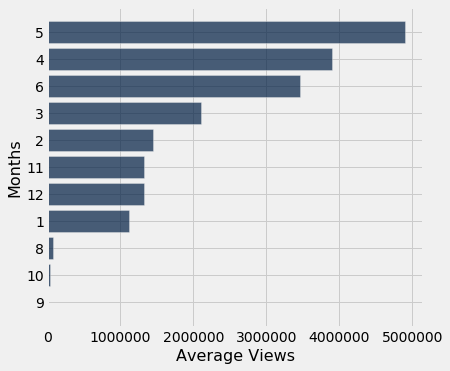

In [16]:
months_view.barh('Months')

In [18]:
# Days, in descending order, of highest average views and the standard deviation

days_view = months_and_days.select('Days', 'views').group('Days', np.average).sort('views average', descending=True).relabel('views average', 'Average Views')
std_view_day = np.std(days_view.column('Average Views'))

print('The standard deviation for average views by day is', std_view_day)
days_view

The standard deviation for average views by day is 922186.378081638


Days,Average Views
6,5.89435e+06
4,4.03489e+06
24,3.6381e+06
18,3.3347e+06
9,3.17047e+06
10,3.11943e+06
20,2.90616e+06
12,2.86068e+06
29,2.80425e+06
3,2.57964e+06


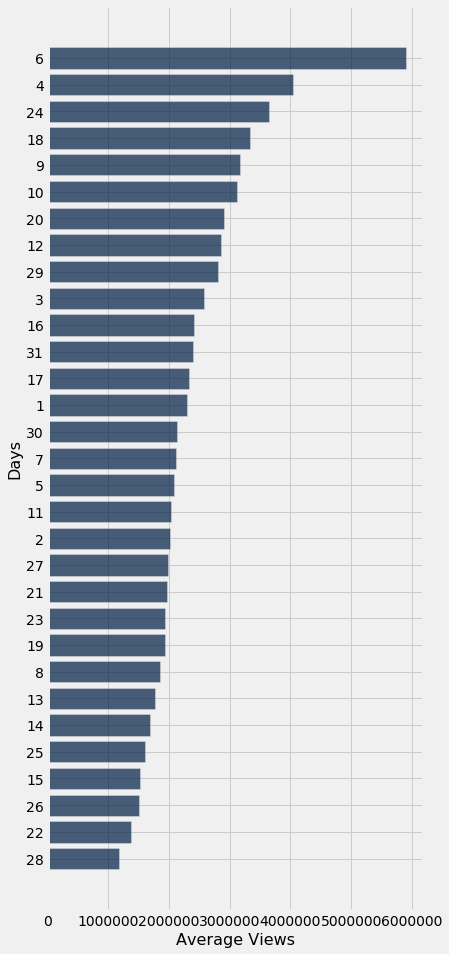

In [20]:
days_view.barh('Days')

In [22]:
# Highest average view date

avg_views_date.sort('average views', descending=True).take(0).relabel('average views', 'Average Views')

Months,Days,Average Views
5,6,2.30554e+07


### Conclusion of Question 4

>Based on the dates of when the trending videos were published, the date with the highest average view was on **May 6th**, with around 23 million views.

>The month where the trending videos received the most average views was in **May**. An interesting observation is that the top five months for highest average views for trending videos were between February and May, and the lowest months were between August and October.
 
>On the other hand, the highest average view for trending videos was on the **sixth of each month**, with the 28th being the lowest.

### Question 5: What is the Relationship Between Total Views, Total Likes, and the Number of Trending Videos by a YouTube Channel?

In [23]:
# Number of times a YouTube channel trended and their respective total views and total likes

number_trend = dropped_columns.select('channel_title', 'views', 'likes').group('channel_title').sort('count', descending=True)
views_and_likes_sum = dropped_columns.select('channel_title', 'views', 'likes').group('channel_title', sum).sort('views sum', descending=True)
joined_count = views_and_likes_sum.join('channel_title', number_trend).sort('count', descending=True)
joined_count.show(1)

channel_title,views sum,likes sum,count
ESPN,105654218,937723,203


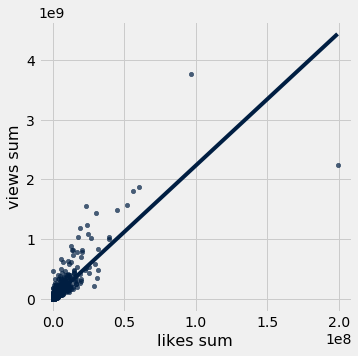

In [37]:
joined_count.scatter('likes sum', 'views sum', fit_line=True)

As seen in the scatter plot above, there is a positive correlation between the total number of likes and total number of views for each channel. There are two outliers, one where the sum of likes is around 200 million and one where the sum of views is around four billion. The outliers are shown in the table below.

In [38]:
top_view = joined_count.sort('views sum', descending=True).column('channel_title').item(0)
top_like = joined_count.sort('likes sum', descending=True).column('channel_title').item(0)
like_outlier = joined_count.where('channel_title', are.equal_to(make_array(top_view, top_like)))
like_outlier

/opt/anaconda3/lib/python3.7/site-packages/datascience/predicates.py:261: SyntaxWarning: Do not pass an array or list to a predicate.                 If you are trying to find rows where two columns are the                 same, use table.where('c', are.equal_to, table.column('d'))                instead of table.where('c', are.equal_to(table.column('d'))).
  SyntaxWarning)


channel_title,views sum,likes sum,count
ibighit,2235906679,199247121,80
ChildishGambinoVEVO,3758488765,96700818,25


> From a further search on Google, both outliers are popular music channels! 

In [39]:
# Calculating the regression line

def standard_units(array):
    '''Returns array in standard units'''
    return (array - np.mean(array)) / np.std(array)

def correlation(t, label_x, label_y):
    '''Returns correlation between label_x and label_y in table t'''
    return np.mean(standard_units(t.column(label_x)) * standard_units(t.column(label_y)))

def slope(t, label_x, label_y):
    '''Returns slope of regression line'''
    r = correlation(t, label_x, label_y)
    return r * np.std(t.column(label_y)) / np.std(t.column(label_x))

def intercept(t, label_x, label_y):
    '''Returns slope of intercept line'''
    return np.mean(t.column(label_y)) - slope(t, label_x, label_y) * np.mean(t.column(label_x))

In [40]:
correlation = correlation(joined_count, 'likes sum', 'views sum')
correlation

0.8418461559044312

In [42]:
slope = slope(joined_count, 'likes sum', 'views sum')
slope

22.17141

In [236]:
intercept = intercept(joined_count, 'likes sum', 'views sum')
intercept

13251134.372646272

> The scatter plot has a correlation of 0.84, and the regression line is y = 22.17141 * x + 13251134.37 (slope of 22.17141 and y-intercept of 13251134.37).

In [24]:
# Sorted in descending order of number of trending videos from each channel

joined_count

channel_title,views sum,likes sum,count
ESPN,105654218,937723,203
The Tonight Show Starring Jimmy Fallon,271426383,5981334,197
Vox,122633963,3272518,193
TheEllenShow,253841999,6035132,193
Netflix,185818315,4211072,193
The Late Show with Stephen Colbert,123675646,1511686,187
Jimmy Kimmel Live,285418753,4844377,186
Late Night with Seth Meyers,181602246,2098813,183
Screen Junkies,319075554,8836325,182
NBA,72404568,878898,181


In [25]:
# Sorted in descending order of number of total views from each channel

joined_count.sort('views sum', descending=True)

channel_title,views sum,likes sum,count
ChildishGambinoVEVO,3758488765,96700818,25
ibighit,2235906679,199247121,80
Dude Perfect,1870085178,60275557,131
Marvel Entertainment,1808998971,55873344,125
ArianaGrandeVevo,1576959172,52170970,43
MalumaVEVO,1551515831,23278380,32
jypentertainment,1486972132,44900910,64
Sony Pictures Entertainment,1432374398,30106808,88
FoxStarHindi,1238609854,23762509,32
BeckyGVEVO,1182971286,19185287,20


In [26]:
# Sorted in descending order of number of total likes from each channel

joined_count.sort('likes sum', descending=True)

channel_title,views sum,likes sum,count
ibighit,2235906679,199247121,80
ChildishGambinoVEVO,3758488765,96700818,25
Dude Perfect,1870085178,60275557,131
Marvel Entertainment,1808998971,55873344,125
ArianaGrandeVevo,1576959172,52170970,43
jypentertainment,1486972132,44900910,64
TaylorSwiftVEVO,1010955662,39292840,49
Ed Sheeran,1032288961,39279211,47
ZaynVEVO,838561451,31695245,39
Logan Paul Vlogs,484356303,31545290,24


In [30]:
print('Average number of trending videos for channels that were top ten in terms of total views:' ,
      np.mean(joined_count.sort('views sum', descending=True).column('count')), 'videos')

Average number of trending videos for channels that were top ten in terms of total views: 18.554145899410965 videos


### Conclusion of Question 5

> Higher amount of total likes correlated with a higher amount of total views.

> The highest number of trending videos from YouTube channels did not result in the most total views or most total likes. In fact, channels that were top ten in terms of total views had only an average of 19 trending videos, and the majority of the channels were from either the music or entertainment industry.

# Conclusion 

* There are various correlations between features of trending YouTube videos


* Correlation **DOES NOT** equal causation


* Numerous confounding factors, such as a larger YouTube user base over time, led to less accurate results 


> ### Future Improvements:

* Use datasets that contain more significant features (i.e. subscribers)


* Group data into smaller time frames to obtain a more accurate analysis


* Use a more powerful device that can run for loops faster (had to decrease the number of bootstraps and for loops  due to runtime error and kernal dying after a period of time)

  
>### Summary of Findings on Trending YouTube Videos:

1. **All Capital Letter Title Videos:** All capital letter title videos tend to perform worse in terms of views, on average, than non-all capital letter title videos.


2. **Disabled Comments:** Disabled comments tend to have less views, on average, compared to non-disabled comment videos.


3. **Video Descriptions:** Shorter description lengths correlated to a higher amount of views.


4. **Highest Average View Dates:** The highest amount of average views for trending videos was on May 6th, and the top four months were between February and May, with the sixth as the top day for highest amount of average views.


5. **Total Likes and Total Views:** The highest total amount of views and likes were mainly from music channels with popular artists.

#### Work Cited

J., Mitchell. 2019. Trending YouTube Video Statistic. YouTube API. Distributed by Kaggle. www.kaggle.com/datasnaek/youtube-new.